In [34]:
import os
if 'ROOT_PATH' in os.environ:
    ROOT_PATH = os.environ['ROOT_PATH']
else:
    ROOT_PATH = '/homes/ar2342/one_more_dir/contextual_frogs/'
    os.environ['ROOT_PATH'] = ROOT_PATH
    
import sys
sys.path.append(ROOT_PATH)

In [35]:
from coin_if import COINWrapper,read_COIN_params

In [36]:
from __future__ import absolute_import
import importlib


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from models import MLP, OneOverSqr
from runners import wrap_runner_for_optimization
from fitting_utils import create_fitting_loss
from dsp_utils import smooth_signal

from types import SimpleNamespace

In [37]:
# from coin_if import read_COIN_params
# raw_coin_params = read_COIN_params('/fitted_parameters/')

In [38]:
args = SimpleNamespace()
args.paradigm = ['evoked', 'spontaneous']

paradigm_short = {
    'evoked': 'E',
    'spontaneous': 'S'
}

paradigm_info = {
    'evoked': {
        'i_min': 1,
        'i_max': 8,},

    'spontaneous': {
        'i_min': 1,
        'i_max': 8,}
    }



In [39]:
data = {}
opt_data = {}
paradigm_by_id_lut = {}
id = 0
# param_names = [k for k in raw_coin_params['E1'].keys()]

if type(args.paradigm) is not str:
    for paradigm in args.paradigm:
        for i in range(paradigm_info[paradigm]['i_min'],paradigm_info[paradigm]['i_max']+1):
            # with open(f'../results/sweek_with_shift_{i}.pkl','rb') as f:
            # with open(f'{ROOT_PATH}/experimental/coin_{args.paradigm}_run011s_MSE_{i}.pkl','rb') as f:
            
            with open(f'{ROOT_PATH}/results/coin_{paradigm}_run012_MSE_{i}.pkl','rb') as f:
                opt_data[id] = pickle.load(f)
            # kk = paradigm_short[paradigm]+str(i)
            # opt_data[id] = {'MSE':{'x':[raw_coin_params[kk][p] for p in param_names]}}
            
            paradigm_by_id_lut[id] = paradigm

            df = pd.read_csv(f'{ROOT_PATH}/../../frogs_project/data/COIN_data/trial_data_{paradigm}_recovery_participant{i}.csv')
            y = df.Adaptation.to_numpy()
            y *= np.sign(np.nansum(y))
            data[id] = y

            id += 1

In [40]:
opt_data

{0: {'MSE':                     message: ['requested number of basinhopping iterations completed successfully']
                      success: True
                          fun: 0.0193122692951781
                            x: [-5.011e+00  1.374e-01  2.269e-01  1.080e+00]
                          nit: 300
        minimization_failures: 81
                         nfev: 30330
                         njev: 6066
   lowest_optimization_result:  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
                                success: True
                                 status: 0
                                    fun: 0.0193122692951781
                                      x: [-5.011e+00  1.374e-01  2.269e-01
                                           1.080e+00]
                                    nit: 2
                                    jac: [ 9.508e+02  3.056e+04  6.360e+03
                                           1.628e+04]
                                   nfev: 115

In [105]:
def scale_and_bias(x,bias=0,scale=45.0):
    x = np.array(x)
    return x*scale + bias
fixed_params = {}


fixed_params['model'] =  dict(n_inputs = 4,
                        n_hidden = 5*4*512,
                        n_outs = 1,
                        en_bias = False,
                        first_layer_init='uniform_unity',
                    first_layer_weights_trainable = True,
                    out_layer_init='zeros',
                        nl = 'relu')        

fixed_params['runner'] = {'criterion':'MSE', 'k':[0,0,0,1], 'tau_u':1,
                        'save_model_at_init':False, 'ic_param_file':None, 'enable_combo':True, 'noise_spec':{'noi_x':0.1}}

optim_param_mapping= [('custom','normalized_log_lr'),
                    ('model','skip_gain'),                      
                    ('model','b_high'),                      
                    ('postprocessing','scale'),
                    ]
custom_param_mappings = [{'cathegory':'runner','param_name':'learning_rate',
                            'fun': lambda x: 10.**x['normalized_log_lr']}]

wrapped_runner = wrap_runner_for_optimization(model_class=MLP, 
                                             fixed_params=fixed_params,
                                             optim_params_mapping=optim_param_mapping,
                                              custom_param_mappings =custom_param_mappings,
                                             postprocessing_fun=scale_and_bias)


In [106]:
Pplus = 1
Pminus = -1
P0 = 0
Pchannel = np.nan

'''
spontaneous:
trials in block Null: 50
trials in block FieldA: 120
trials in block PostRest: 5
trials in block FieldB: 15
trials in block Clamp150: 150


evoked:
trials in block Null: 50
trials in block FieldA: 120
trials in block PostRest: 5
trials in block FieldB: 15
trials in block Clamp2: 2
trials in block FieldA2: 2
trials in block Clamp150: 146
'''
stimuli = {'spontaneous': [(P0, 50),
                        (Pplus, 125),
                        (Pminus, 15),
                        (Pchannel, 150)],
            'evoked': [(P0, 50),
                        (Pplus, 125),
                        (Pminus, 15),
                        (Pchannel, 2),
                        (Pplus, 2),
                        (Pchannel, 146)]}

# data = {}
# id = 0
# for , paradigm in paradigm_by_id_lut.items():
    
# stimulus = stimuli[args.paradigm]
datapoint_mapping=None

In [107]:
pooling_fun = 'MSE'

In [111]:
outs  = {k: wrapped_runner(stimuli[paradigm_by_id_lut[k]],opt_data[k][pooling_fun]['x']) for k in opt_data}

In [109]:
trials = 100
outs_mult = {k: [wrapped_runner(stimuli[paradigm_by_id_lut[k]],opt_data[k][pooling_fun]['x'])   for _ in range(trials)]  for k in opt_data} 

Text(0.5, 1.0, 'subjects -->>1')

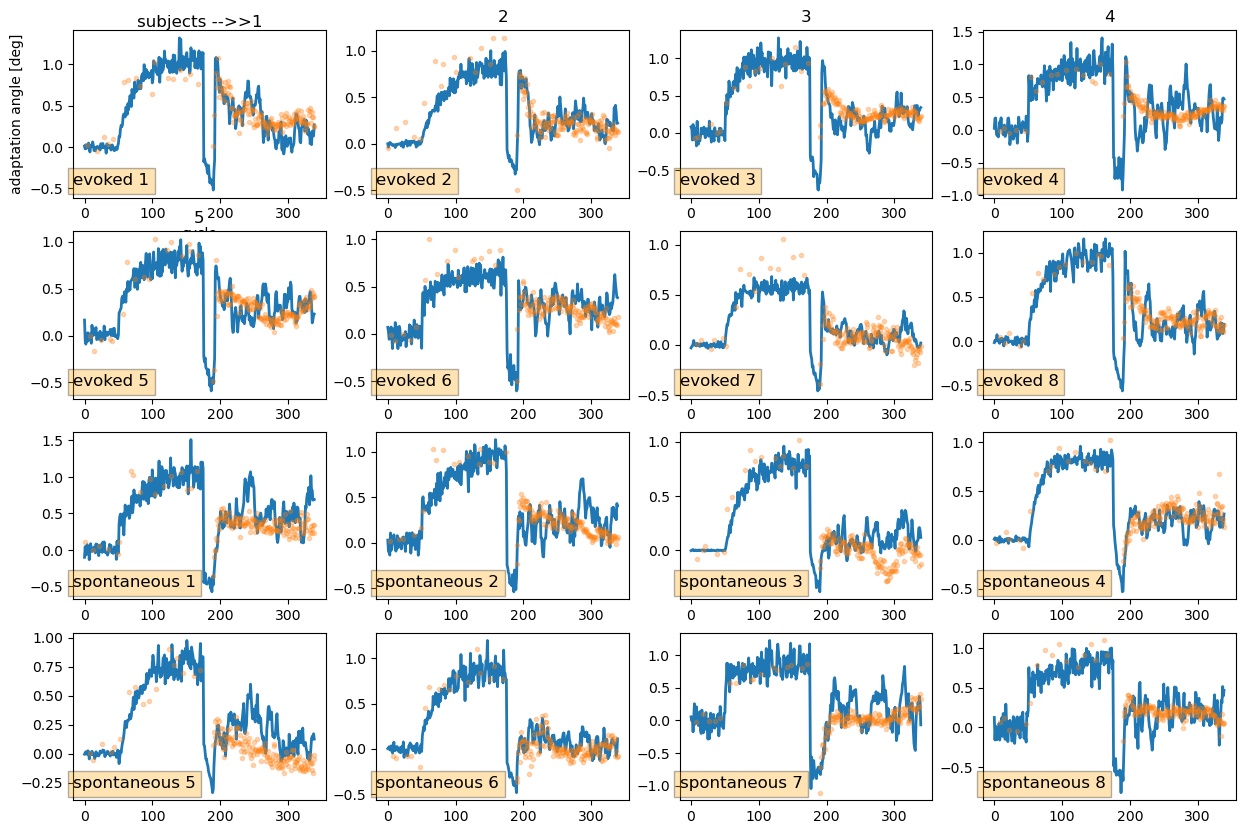

In [112]:
plt.figure(figsize=(15,10))
for k in opt_data:
    plt.subplot(4,4,k+1)
    ydata_model = outs[k]
    xdata_model = np.arange(1,len(ydata_model)+1)
    ydata_experiment = data[k]
    xdata_experiment = np.arange(1,len(ydata_experiment)+1)
    #remove nans
    xdata_model = xdata_model[~np.isnan(ydata_model)]
    ydata_model = ydata_model[~np.isnan(ydata_model)]
    xdata_experiment = xdata_experiment[~np.isnan(ydata_experiment)]
    ydata_experiment = ydata_experiment[~np.isnan(ydata_experiment)]
    # output as csv
    # np.savetxt(f'{ROOT_PATH}/results/coin_fit12_subj_{k+1}_model.csv', np.array([xdata_model,ydata_model]).T, delimiter=',')
    # np.savetxt(f'{ROOT_PATH}/results/coin_fit12_subj_{k+1}_experiment.csv', np.array([xdata_experiment,ydata_experiment]).T, delimiter=',')

    plt.plot(outs[k],linewidth=2)
    plt.plot(data[k],'.', alpha=0.3)
    if k<5: plt.title(f'{k+1}')
    plt.text(0.0, 0.1, f'{paradigm_by_id_lut[k]} {k%8+1}', 
                 horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12,
                 bbox=dict(facecolor='orange', alpha=0.3))



plt.subplot(4,4,1)
plt.ylabel('adaptation angle [deg]')
plt.xlabel('cycle')

plt.gca().set_title(f'subjects -->>{1}', pad=-30)



# plt.legend(['model','validation data','fitted data'])    
    
# plt.plot(data[:80,0],'.')
# plt.plot(smooth_signal(data[:,0],3))


In [ ]:
import pickle
# with open(f'{ROOT_PATH}/results/noisy_coin_fit12_noi_x0p05.pkl','wb') as f:
#     pickle.dump([outs,outs_mult],f)

Text(0.5, 1.0, 'subjects -->>1')

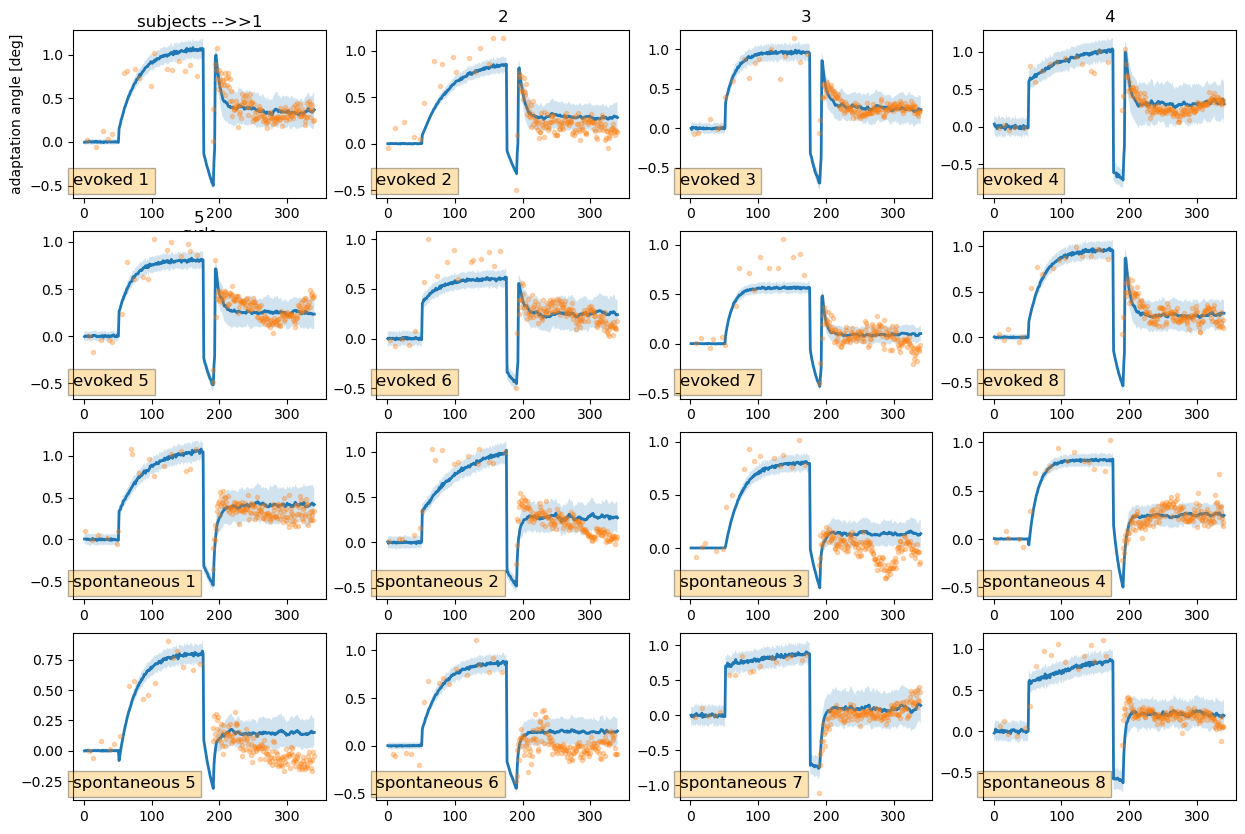

In [141]:
plt.figure(figsize=(15,10))
for k in opt_data:
    plt.subplot(4,4,k+1)
    ydata_model_mean = np.mean(outs_mult[k], axis=0)
    ydata_model_std = np.std(outs_mult[k], axis=0)
    xdata_model = np.arange(1,len(ydata_model_mean)+1)
    ydata_experiment = data[k]
    xdata_experiment = np.arange(1,len(ydata_experiment)+1)
    #remove nans
    xdata_model = xdata_model[~np.isnan(ydata_model_mean)]
    ydata_model_mean = ydata_model_mean[~np.isnan(ydata_model_mean)]
    ydata_model_std = ydata_model_std[~np.isnan(ydata_model_mean)]

    ydata_experiment = ydata_experiment[~np.isnan(ydata_experiment)]
    # output as csv
    # np.savetxt(f'{ROOT_PATH}/results/coin_fit12_subj_{k+1}_model.csv', np.array([xdata_model,ydata_model]).T, delimiter=',')
    # np.savetxt(f'{ROOT_PATH}/results/coin_fit12_subj_{k+1}_experiment.csv', np.array([xdata_experiment,ydata_experiment]).T, delimiter=',')
    k_draw = 1
    plt.plot(xdata_model,ydata_model_mean,linewidth=2)
    plt.fill_between(xdata_model, ydata_model_mean - k_draw*ydata_model_std, ydata_model_mean + k_draw*ydata_model_std, alpha=0.2)


    plt.plot(data[k],'.', alpha=0.3)
    if k<5: plt.title(f'{k+1}')
    plt.text(0.0, 0.1, f'{paradigm_by_id_lut[k]} {k%8+1}', 
                 horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12,
                 bbox=dict(facecolor='orange', alpha=0.3))



plt.subplot(4,4,1)
plt.ylabel('adaptation angle [deg]')
plt.xlabel('cycle')

plt.gca().set_title(f'subjects -->>{1}', pad=-30)



# plt.legend(['model','validation data','fitted data'])    
    
# plt.plot(data[:80,0],'.')
# plt.plot(smooth_signal(data[:,0],3))


Text(0.5, 1.0, 'subjects -->>1')

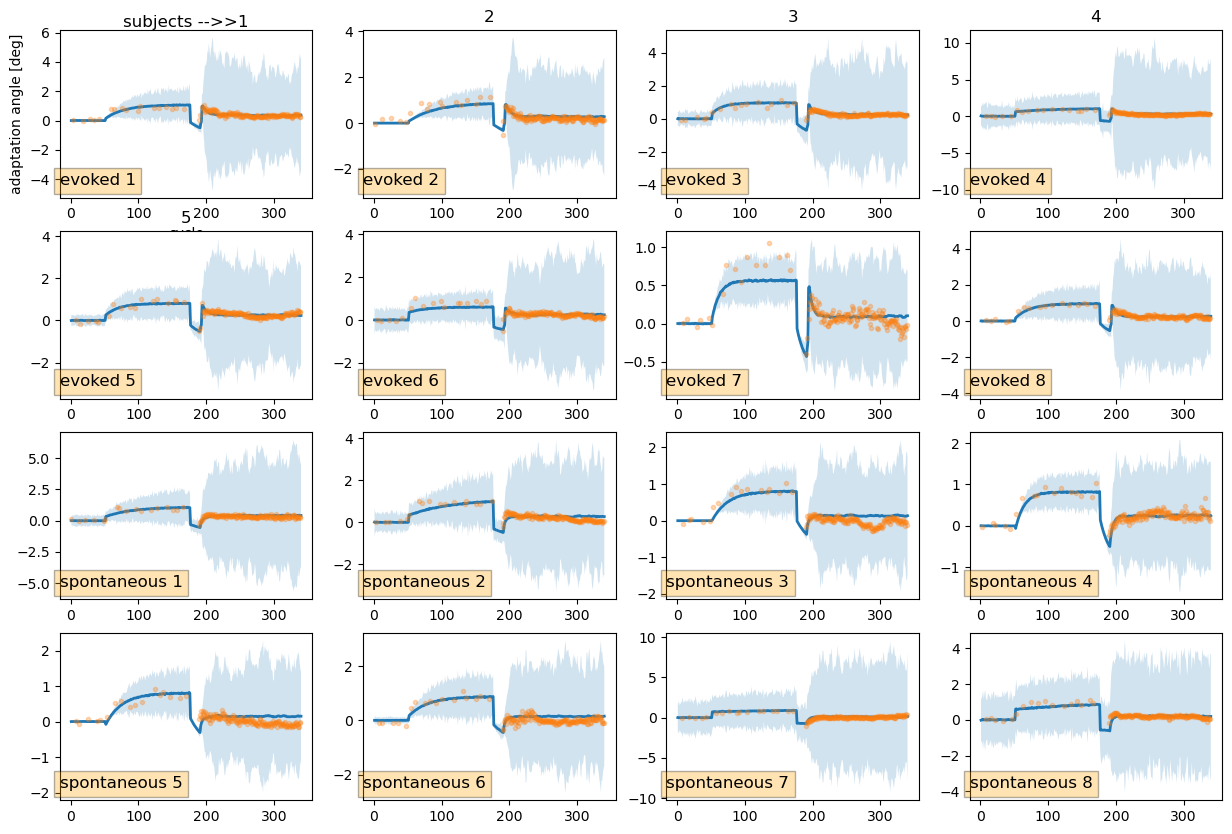

In [114]:
plt.figure(figsize=(15,10))
for k in opt_data:
    plt.subplot(4,4,k+1)
    ydata_model_mean = np.mean(outs_mult[k], axis=0)
    ydata_model_std = np.std(outs_mult[k], axis=0)
    xdata_model = np.arange(1,len(ydata_model_mean)+1)
    ydata_experiment = data[k]
    xdata_experiment = np.arange(1,len(ydata_experiment)+1)
    #remove nans
    xdata_model = xdata_model[~np.isnan(ydata_model_mean)]
    ydata_model_mean = ydata_model_mean[~np.isnan(ydata_model_mean)]
    ydata_model_std = ydata_model_std[~np.isnan(ydata_model_mean)]

    ydata_experiment = ydata_experiment[~np.isnan(ydata_experiment)]
    # output as csv
    # np.savetxt(f'{ROOT_PATH}/results/coin_fit12_subj_{k+1}_model.csv', np.array([xdata_model,ydata_model]).T, delimiter=',')
    # np.savetxt(f'{ROOT_PATH}/results/coin_fit12_subj_{k+1}_experiment.csv', np.array([xdata_experiment,ydata_experiment]).T, delimiter=',')
    k_draw = 100
    plt.plot(xdata_model,ydata_model_mean,linewidth=2)
    plt.fill_between(xdata_model, ydata_model_mean - k_draw*ydata_model_std**2, ydata_model_mean + k_draw*ydata_model_std**2, alpha=0.2)


    plt.plot(data[k],'.', alpha=0.3)
    if k<5: plt.title(f'{k+1}')
    plt.text(0.0, 0.1, f'{paradigm_by_id_lut[k]} {k%8+1}', 
                 horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12,
                 bbox=dict(facecolor='orange', alpha=0.3))



plt.subplot(4,4,1)
plt.ylabel('adaptation angle [deg]')
plt.xlabel('cycle')

plt.gca().set_title(f'subjects -->>{1}', pad=-30)

In [169]:
from scipy.stats import linregress

def nanlinregress(x, y, return_unexp_var=False):
    mask = ~np.isnan(x) & ~np.isnan(y)
    lr = linregress(x[mask], y[mask])
    if return_unexp_var:
        y_pred = lr.intercept + lr.slope * x
        unexp_var = np.nanmean((y - y_pred) ** 2)
        return lr, unexp_var
    else:
        return lr

In [170]:
plt.figure(figsize=(15,10))
rms = lambda x: np.sqrt(np.mean(x**2))
data_std_0 = []
data_std_A = []
data_std_C = []
fit_std_0 = []
fit_std_A = []
fit_std_C = []

data_varLR_0 = []
data_varLR_A = []
data_varLR_C = []
fit_varLR_0 = []
fit_varLR_A = []
fit_varLR_C = []

zz= 200

for k in opt_data:
    ydata_model_mean = np.mean(outs_mult[k], axis=0)
    ydata_model_std = np.std(outs_mult[k], axis=0)
    xdata_model = np.arange(1,len(ydata_model_mean)+1)
    ydata_experiment = data[k]
    xdata_experiment = np.arange(1,len(ydata_experiment)+1)

    data_std_0.append(np.nanstd(data[k][:50]))
    data_std_A.append(np.nanstd(data[k][50+125-50:50+125]))
    data_std_C.append(np.nanstd(data[k][-50:]))
    fit_std_0.append(rms(ydata_model_std[:50]))
    fit_std_A.append(rms(ydata_model_std[50+125-50:50+125]))
    fit_std_C.append(rms(ydata_model_std[-50:]))

    # linear regression
    data_varLR_0.append(nanlinregress(zz*xdata_experiment[:50], data[k][:50], return_unexp_var=True)[-1])
    data_varLR_A.append(nanlinregress(zz*xdata_experiment[50+125-50:50+125], data[k][50+125-50:50+125], return_unexp_var=True)[-1])
    data_varLR_C.append(nanlinregress(zz*xdata_experiment[-50:], data[k][-50:], return_unexp_var=True)[-1])
    # fit_varLR_0.append(nanlinregress(xdata_model[:50], ydata_model_mean[:50], return_unexp_var=True)[-1])
    # fit_varLR_A.append(nanlinregress(xdata_model[50+125-50:50+125], ydata_model_mean[50+125-50:50+125], return_unexp_var=True)[-1])
    # fit_varLR_C.append(nanlinregress(xdata_model[-50:], ydata_model_mean[-50:], return_unexp_var=True)[-1])

    #remove nans
    xdata_model = xdata_model[~np.isnan(ydata_model_mean)]
    ydata_model_mean = ydata_model_mean[~np.isnan(ydata_model_mean)]
    ydata_model_std = ydata_model_std[~np.isnan(ydata_model_mean)]

    ydata_experiment = ydata_experiment[~np.isnan(ydata_experiment)]
    # output as csv
    # np.savetxt(f'{ROOT_PATH}/results/coin_fit12_subj_{k+1}_model.csv', np.array([xdata_model,ydata_model]).T, delimiter=',')
    # np.savetxt(f'{ROOT_PATH}/results/coin_fit12_subj_{k+1}_experiment.csv', np.array([xdata_experiment,ydata_experiment]).T, delimiter=',')
#     k_draw = 3
#     plt.plot(xdata_model,ydata_model_mean,linewidth=2)
#     plt.fill_between(xdata_model, ydata_model_mean - k_draw*ydata_model_std, ydata_model_mean + k_draw*ydata_model_std, alpha=0.2)


#     plt.plot(data[k],'.', alpha=0.3)
#     if k<5: plt.title(f'{k+1}')
#     plt.text(0.0, 0.1, f'{paradigm_by_id_lut[k]} {k%8+1}', 
#                  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12,
#                  bbox=dict(facecolor='orange', alpha=0.3))



# plt.subplot(4,4,1)
# plt.ylabel('adaptation angle [deg]')
# plt.xlabel('cycle')

# plt.gca().set_title(f'subjects -->>{1}', pad=-30)



# # plt.legend(['model','validation data','fitted data'])    
    
# # plt.plot(data[:80,0],'.')
# # plt.plot(smooth_signal(data[:,0],3))


<Figure size 1500x1000 with 0 Axes>

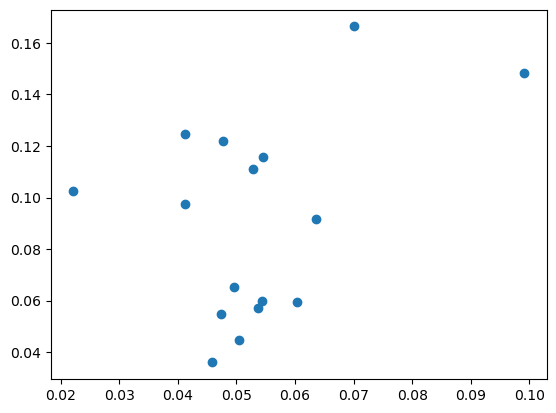

In [171]:
plt.plot(data_std_0, data_std_A, 'o')

(array([1., 1., 1., 3., 1., 0., 0., 0., 1., 1., 1., 1., 1., 2., 0., 0., 0.,
        1., 0., 1.]),
 array([0.03601425, 0.04253313, 0.04905201, 0.05557089, 0.06208977,
        0.06860865, 0.07512753, 0.08164641, 0.08816529, 0.09468417,
        0.10120305, 0.10772193, 0.11424081, 0.12075969, 0.12727857,
        0.13379745, 0.14031633, 0.14683521, 0.15335408, 0.15987296,
        0.16639184]),
 <BarContainer object of 20 artists>)

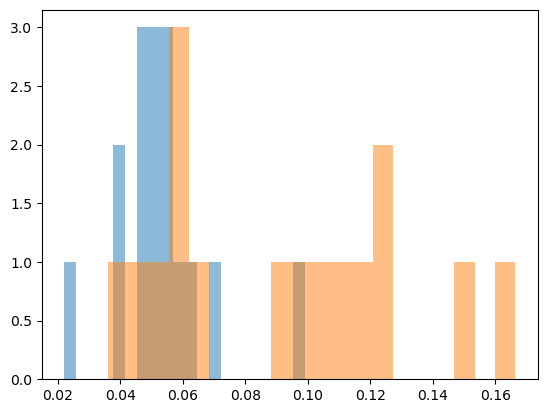

In [159]:
bins = np.linspace(0, 0.15, 10)
plt.hist(data_std_0, bins=20, alpha=0.5, label='std 0')
plt.hist(data_std_A, bins=20, alpha=0.5, label='std A')

In [160]:
from scipy.stats import ranksums
# print(f'p-value for ranksum: {ranksums(data_std_0, data_std_A).pvalue}')
print(f'DATA: mean std 0: {np.mean(data_std_0):0.3}, mean std A: {np.mean(data_std_A):0.3}   p-val (ranksum): {ranksums(data_std_0, data_std_A).pvalue:0.4}')
print(f'DATA: mean std A: {np.mean(data_std_A):0.3}, mean std C: {np.mean(data_std_C):0.3}   p-val (ranksum): {ranksums(data_std_A, data_std_C).pvalue:0.4}')

print(f'FIT: mean std 0: {np.mean(fit_std_0):0.3}, mean std A: {np.mean(fit_std_A):0.3}   p-val (ranksum): {ranksums(fit_std_0, fit_std_A).pvalue:0.4}')
print(f'FIT: mean std A: {np.mean(fit_std_A):0.3}, mean std C: {np.mean(fit_std_C):0.3}   p-val (ranksum): {ranksums(fit_std_A, fit_std_C).pvalue:0.4}')




# print(f'p-value for ranksum test between std 0 (fit) and std A (fit): {ranksums(fit_std_0, fit_std_A).pvalue}')
# print(f'mean fit std 0: {np.mean(fit_std_0)}, mean fit std A: {np.mean(fit_std_A)}')

DATA: mean std 0: 0.0534, mean std A: 0.0911   p-val (ranksum): 0.002569
DATA: mean std A: 0.0911, mean std C: 0.0766   p-val (ranksum): 0.3271
FIT: mean std 0: 0.0541, mean std A: 0.0979   p-val (ranksum): 0.001998
FIT: mean std A: 0.0979, mean std C: 0.164   p-val (ranksum): 7.579e-05


(array([1., 0., 1., 0., 0., 3., 2., 1., 1., 0., 2., 1., 1., 0., 1., 0., 0.,
        0., 1., 1.]),
 array([0.05482324, 0.05958983, 0.06435642, 0.06912301, 0.0738896 ,
        0.07865619, 0.08342278, 0.08818937, 0.09295596, 0.09772255,
        0.10248913, 0.10725572, 0.11202231, 0.1167889 , 0.12155549,
        0.12632208, 0.13108867, 0.13585526, 0.14062185, 0.14538844,
        0.15015503]),
 <BarContainer object of 20 artists>)

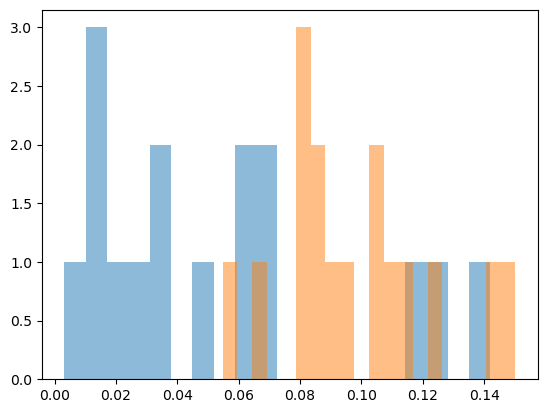

In [161]:
bins = np.linspace(0, 0.15, 10)
plt.hist(fit_std_0, bins=20, alpha=0.5, label='std 0')
plt.hist(fit_std_A, bins=20, alpha=0.5, label='std A')

Text(0, 0.5, 'fit')

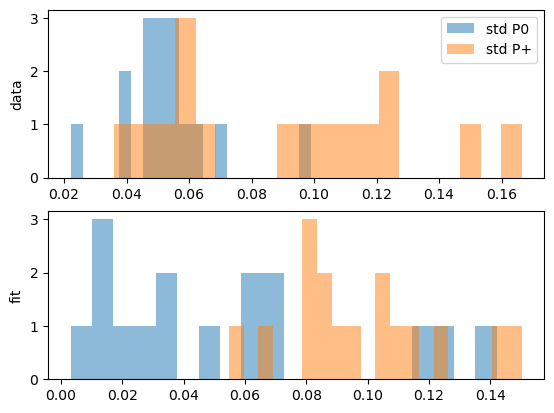

In [162]:
bins = np.linspace(0, 0.15, 10)
plt.subplot(2,1,1)
plt.hist(data_std_0, bins=20, alpha=0.5, label='std P0')
plt.hist(data_std_A, bins=20, alpha=0.5, label='std P+')
plt.legend()

plt.ylabel('data')

plt.subplot(2,1,2)
plt.hist(fit_std_0, bins=20, alpha=0.5, label='std 0')
plt.hist(fit_std_A, bins=20, alpha=0.5, label='std A')
plt.ylabel('fit')

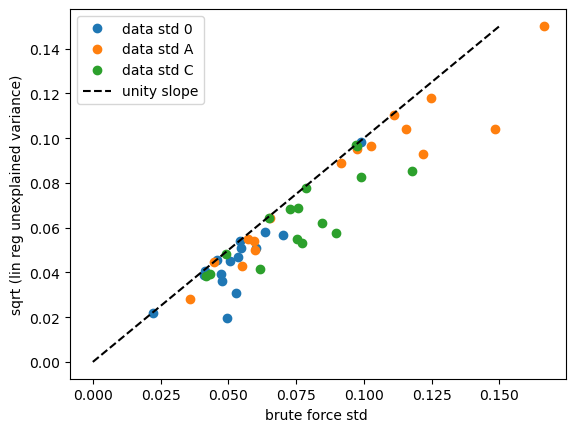

In [180]:
plt.plot(data_std_0, np.sqrt(data_varLR_0), 'o', label='data std 0')
plt.plot(data_std_A, np.sqrt(data_varLR_A), 'o', label='data std A')
# plt.plot(fit_std_0, np.sqrt(fit_varLR_0), 'o', label='fit std 0')
# plt.plot(fit_std_A, np.sqrt(fit_varLR_A), 'o', label='fit std A')
plt.plot(data_std_C, np.sqrt(data_varLR_C), 'o', label='data std C')
# plt.plot(fit_std_C, np.sqrt(fit_varLR_C), 'o', label='fit std C')
plt.xlabel('brute force std ')
plt.ylabel('sqrt (lin reg unexplained variance)')
plt.plot(np.linspace(0, 0.15, 10), np.linspace(0, 0.15, 10), 'k--', label='unity slope')
plt.legend()

Text(0, 0.5, 'fit')

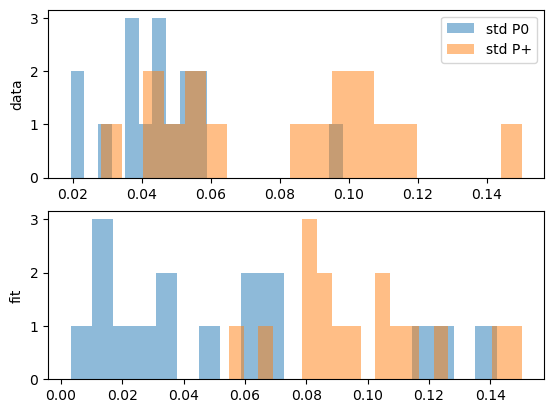

In [174]:
bins = np.linspace(0, 0.15, 10)
plt.subplot(2,1,1)
plt.hist(np.sqrt(data_varLR_0), bins=20, alpha=0.5, label='std P0')
plt.hist(np.sqrt(data_varLR_A), bins=20, alpha=0.5, label='std P+')
plt.legend()

plt.ylabel('data')

plt.subplot(2,1,2)
plt.hist(fit_std_0, bins=20, alpha=0.5, label='std 0')
plt.hist(fit_std_A, bins=20, alpha=0.5, label='std A')
plt.ylabel('fit')

In [176]:
from scipy.stats import ranksums
# print(f'p-value for ranksum: {ranksums(data_std_0, data_std_A).pvalue}')
print(f'DATA: mean std 0: {np.mean(np.sqrt(data_varLR_0)):0.3}, mean std A: {np.mean(np.sqrt(data_varLR_A)):0.3}   p-val (ranksum): {ranksums(np.sqrt(data_varLR_0), np.sqrt(data_varLR_A)).pvalue:0.4}')
print(f'DATA: mean std A: {np.mean(np.sqrt(data_varLR_A)):0.3}, mean std C: {np.mean(np.sqrt(data_varLR_C)):0.3}   p-val (ranksum): {ranksums(np.sqrt(data_varLR_A), np.sqrt(data_varLR_C)).pvalue:0.4}')
print(f'FIT: mean std 0: {np.mean(fit_std_0):0.3}, mean std A: {np.mean(fit_std_A):0.3}   p-val (ranksum): {ranksums(fit_std_0, fit_std_A).pvalue:0.4}')
print(f'FIT: mean std A: {np.mean(fit_std_A):0.3}, mean std C: {np.mean(fit_std_C):0.3}   p-val (ranksum): {ranksums(fit_std_A, fit_std_C).pvalue:0.4}')



DATA: mean std 0: 0.0459, mean std A: 0.0812   p-val (ranksum): 0.003285
DATA: mean std A: 0.0812, mean std C: 0.0648   p-val (ranksum): 0.1632
FIT: mean std 0: 0.0541, mean std A: 0.0979   p-val (ranksum): 0.001998
FIT: mean std A: 0.0979, mean std C: 0.164   p-val (ranksum): 7.579e-05


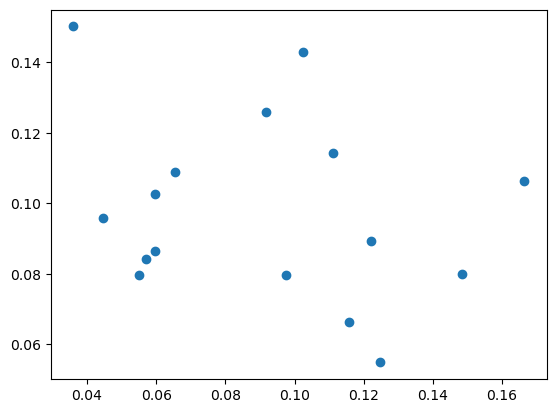

In [134]:
plt.plot(data_std_A, fit_std_A, 'o')

Text(0.1, 0.9, 'Pearson r: 0.151, p-value: 0.578')

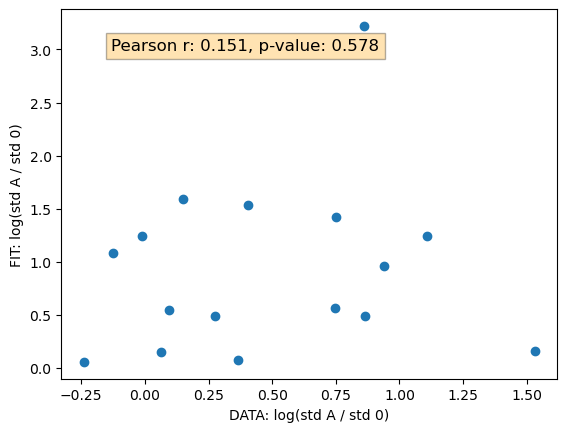

In [147]:
plt.plot(np.log(np.array(data_std_A)/np.array(data_std_0)), np.log(np.array(fit_std_A)/np.array(fit_std_0)), 'o')
plt.xlabel('DATA: log(std A / std 0)')
plt.ylabel('FIT: log(std A / std 0)')
#text: correlation coefficient; pvalue
from scipy.stats import pearsonr
corr_coef, p_value = pearsonr(np.log(np.array(data_std_A)/np.array(data_std_0)), np.log(np.array(fit_std_A)/np.array(fit_std_0)))
plt.text(0.1, 0.9, f'Pearson r: {corr_coef:0.3}, p-value: {p_value:0.3}', 
                 horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12,
                 bbox=dict(facecolor='orange', alpha=0.3))

<Figure size 1500x1000 with 0 Axes>

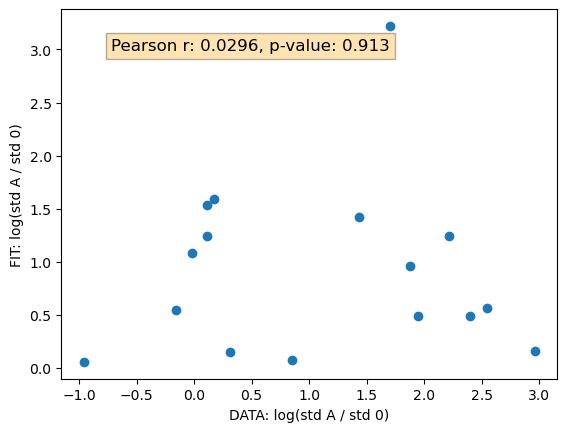

<Figure size 1500x1000 with 0 Axes>

In [175]:
# plt.plot(np.log(np.array(data_std_A)/np.array(data_std_0)), np.log(np.array(fit_std_A)/np.array(fit_std_0)), 'o')
plt.plot(np.log(np.array(data_varLR_A)/np.array(data_varLR_0)), np.log(np.array(fit_std_A)/np.array(fit_std_0)), 'o')
plt.xlabel('DATA: log(std A / std 0)')
plt.ylabel('FIT: log(std A / std 0)')
#text: correlation coefficient; pvalue
from scipy.stats import pearsonr
corr_coef, p_value = pearsonr(np.log(np.array(data_varLR_A)/np.array(data_varLR_0)), 
                              np.log(np.array(fit_std_A)/np.array(fit_std_0)),)
plt.text(0.1, 0.9, f'Pearson r: {corr_coef:0.3}, p-value: {p_value:0.3}', 
                 horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12,
                 bbox=dict(facecolor='orange', alpha=0.3))
plt.figure(figsize=(15,10))


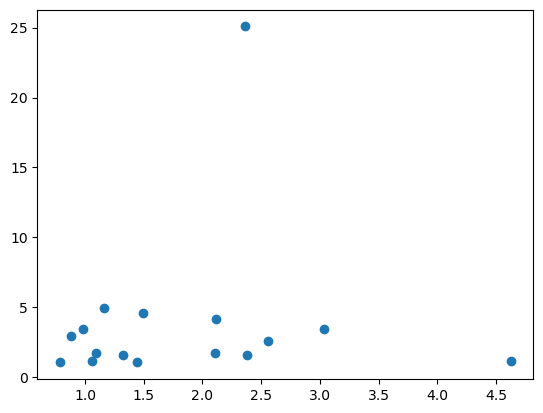

In [136]:
plt.plot(np.array(data_std_A)/np.array(data_std_0), np.array(fit_std_A)/np.array(fit_std_0), 'o')

In [137]:
from scipy.stats import spearmanr, pearsonr

In [138]:
corr_lograt = pearsonr(np.log(np.array(data_std_A)/np.array(data_std_0)), np.log(np.array(fit_std_A)/np.array(fit_std_0)))
corr_rat = pearsonr(np.array(data_std_A)/np.array(data_std_0), np.array(fit_std_A)/np.array(fit_std_0))

In [139]:
corr_lograt

PearsonRResult(statistic=0.15061623968735438, pvalue=0.5776729837761272)

In [140]:
corr_rat

PearsonRResult(statistic=0.11033428979686838, pvalue=0.684167581493178)

Linear regression: slope: 0.992, intercept: 0.259, r-value: 0.998, p-value: 1.65e-119, unexp var: 3.26e+02


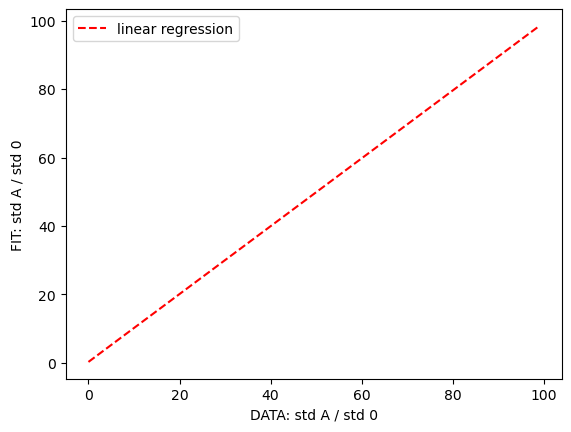

In [168]:
a= np.arange(100)
b = a + np.random.randn(100)*2
ll_ = nanlinregress(a, b, return_unexp_var=True)
ll = ll_[0]
print(f'Linear regression: slope: {ll.slope:0.3}, intercept: {ll.intercept:0.3}, r-value: {ll.rvalue:0.3}, p-value: {ll.pvalue:0.3}, unexp var: {ll_[-1]:0.3}')
plt.plot(a, ll.intercept + ll.slope * a, 'r--', label='linear regression')
plt.xlabel('DATA: std A / std 0')
plt.ylabel('FIT: std A / std 0')
plt.legend()